In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
import yaml
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

/ext3/miniconda3/envs/eqenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sim_name = 'TNG100-1'
#sim_name = 'TNG50-4'
sim_name_dark = f'{sim_name}-Dark'

halo_tag = ''
geo_tag = ''
scalar_tag = ''
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
fit_tag = '_nntest'
fn_model = f'../models/models_{sim_name}/model_{sim_name}{halo_tag}{geo_tag}{scalar_tag}{fit_tag}.pt'

## Load features

In [4]:
fn_halo_config = f'../configs/halos_{sim_name}{halo_tag}.yaml'
print(fn_halo_config)
fn_geo_config = f'../configs/geo_{sim_name}{halo_tag}{geo_tag}.yaml'
print(fn_geo_config)
fn_scalar_config = f'../configs/scalar_{sim_name}{halo_tag}{geo_tag}{scalar_tag}.yaml'
print(fn_scalar_config)

../configs/halos_TNG100-1.yaml
../configs/geo_TNG100-1.yaml
../configs/scalar_TNG100-1.yaml


In [5]:
with open(fn_scalar_config, 'r') as file:
    scalar_params = yaml.safe_load(file)
scp = scalar_params['scalar']

fn_geo_config = scalar_params['geo']['fn_geo_config']
with open(fn_geo_config, 'r') as file:
    geo_params = yaml.safe_load(file)
gp = geo_params['geo']

with open(fn_halo_config, 'r') as file:
    halo_params = yaml.safe_load(file)

fn_dark_halo_arr = halo_params['halo']['fn_dark_halo_arr']

In [6]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(gp['fn_geo_features'])

In [7]:
sim_reader = SimulationReader(halo_params['sim']['base_dir'], sim_name, sim_name_dark, 
                              halo_params['sim']['snap_num_str'])
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [8]:
mrv_for_rescaling = utils.get_mrv_for_rescaling(sim_reader, scp['mrv_names_for_rescaling'])
scalar_featurizer = ScalarFeaturizer(geo_featurizer.geo_feature_arr,
                        n_groups_rebin=scp['n_groups_rebin'], 
                        transform_pseudotensors=scp['transform_pseudotensors'], 
                        mrv_for_rescaling=mrv_for_rescaling)

Rebinning geometric features
Transforming pseudotensors
Rescaling geometric features


In [9]:
x_features_extra = np.log10(mrv_for_rescaling).T

In [10]:
print('loading')
scalar_featurizer.load_features(scp['fn_scalar_features'])
print('loaded')

loading
loaded


In [11]:
y_target_name = 'mass_hydro_subhalo_star'
y_label_name = 'm_stellar'
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')

y = np.array([halo.catalog_properties[y_target_name] for halo in sim_reader.dark_halo_arr])
y = np.log10(y)

## Split train-val-test

In [12]:
frac_train = 0.70
frac_val = 0.15
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, 
                                                      frac_val=frac_val, frac_test=frac_test)

In [13]:
x_test = scalar_featurizer.scalar_features[idx_test]
y_test_current = np.ones(len(x_test))
x_test_extra = x_features_extra[idx_test]
y_test = y[idx_test]

In [27]:
nnfitter = NNFitter(train_mode=False, predict_mode=True)

In [28]:
nnfitter.load_model(fn_model)

(0.0, 3.4909107140179687)

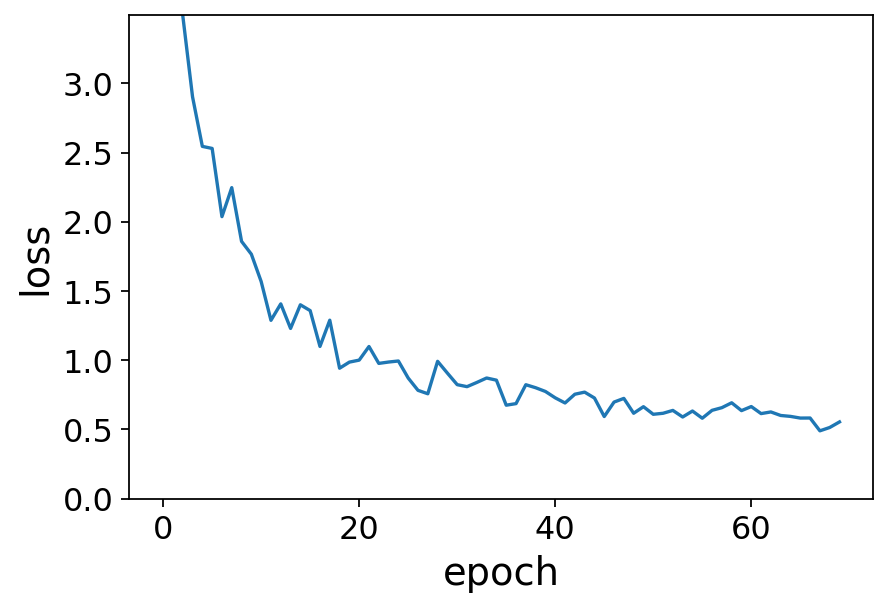

In [33]:
plt.plot(nnfitter.loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, nnfitter.loss[2])

In [30]:
y_pred = nnfitter.predict(x_test, y_test_current, x_extra=x_test_extra)

In [31]:
print(np.min(y_test), np.max(y_test))
print(np.min(y_pred), np.max(y_pred))

-2.411669 2.178211
-2.9491543845995336 2.0671881662714253


/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:315: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


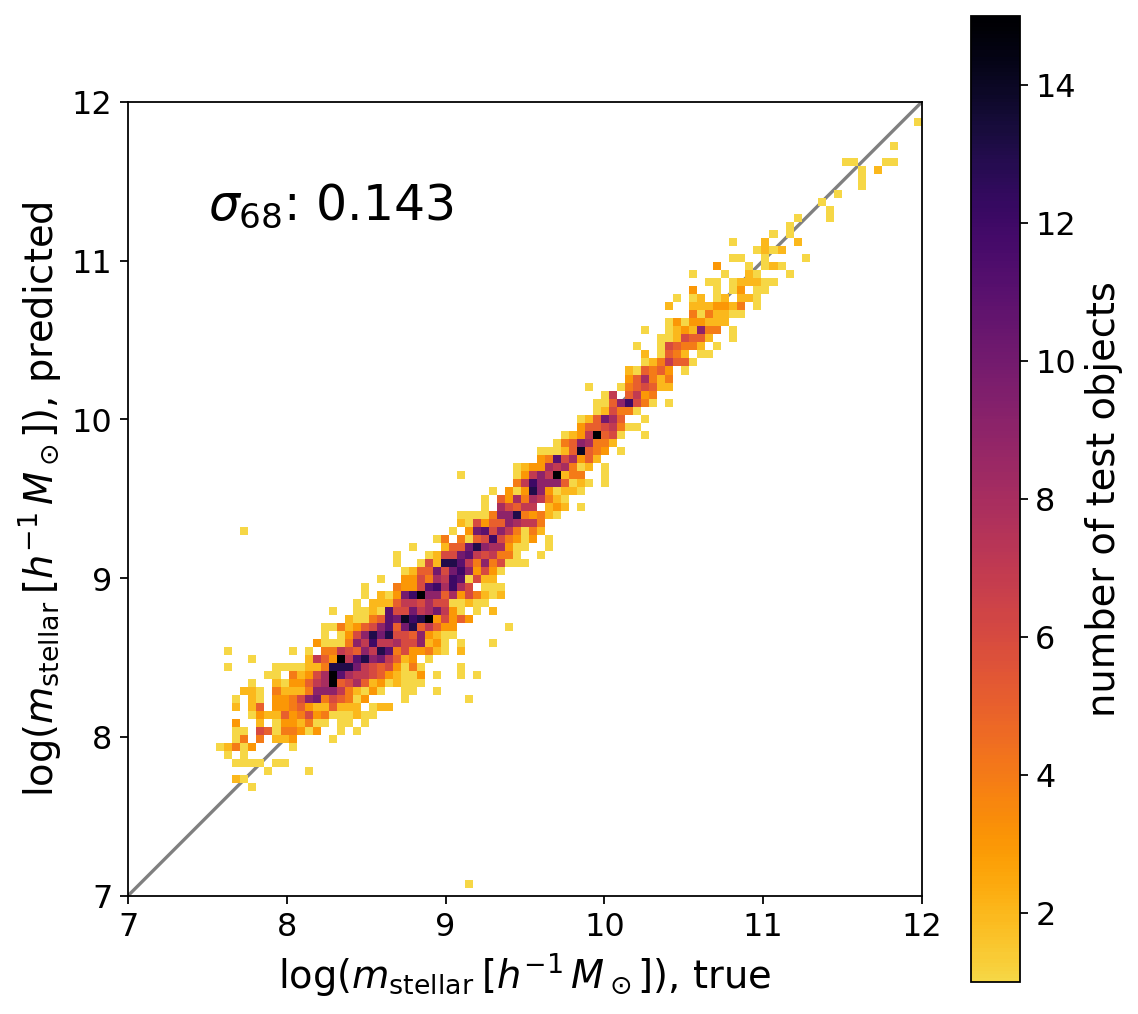

In [32]:
y_test_mult = y_test + log_mass_shift
y_pred_mult = y_pred + log_mass_shift
error_nn, _ = utils.compute_error(y_test_mult, y_pred_mult, test_error_type='percentile')
error_str = fr"$\sigma_{{68}}$: {error_nn:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_test_mult, y_pred_mult, text_results=error_str,
                               x_lim=(7,12),  y_lim=(7,12))